In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna

# To view the entire dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Optuna Logging
import optuna.logging
optuna.logging.set_verbosity(optuna.logging.WARNING) # To disable displaying trial results in hyperparameter tuning

# Read the data

In [2]:
borough = "Staten Island" # "Manhattan" "Brooklyn" "Queens" "Staten Island" "Bronx" "EWR"
ride_type = "Lyft" # "Yellow Taxi" "Green Taxi" "For-Hire Vehicle" "Lyft" "Uber"
filename = rf"../../data/with_feature_engineering/{borough}/{borough}_num_txns_{ride_type}_features.parquet.gz" #
df = pd.read_parquet(filename)

# Get the feature column
target_col = [col for col in df.columns if col.startswith('num_txns_')][0]

df.head()

,txn_date,quarter,month,day_of_month,txn_hour,week_day,is_weekend,is_monday,is_friday,is_holiday,is_holiday_next_day,is_holiday_previous_day,is_long_weekend,is_rush_hour,is_business_hour,is_night_hour,sin_hour,cos_hour,num_txns_Lyft,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_72,lag_96,lag_120,lag_144,lag_164,lag_165,lag_166,lag_167,lag_168,lag_169,lag_68,lag_69,lag_70,lag_71,lag_73,lag_139,lag_140,lag_141,lag_142,lag_143,lag_145,rolling_avg_24_48_72_lags,std_24_48_72_lags,rolling_avg_w1-w4_lags,std_w1-w4_lags
timestamp_hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-01 00:00:00,2019-02-01,1,2,1,0,5,1,0,0,0,0.0,0.0,0,0,0,1,0.000000,1.000000,6180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 01:00:00,2019-02-01,1,2,1,1,5,1,0,0,0,0.0,0.0,0,0,0,1,0.258819,0.965926,3572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 02:00:00,2019-02-01,1,2,1,2,5,1,0,0,0,0.0,0.0,0,0,0,1,0.500000,0.866025,2313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 03:00:00,2019-02-01,1,2,1,3,5,1,0,0,0,0.0,0.0,0,0,0,1,0.707107,0.707107,1811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 04:00:00,2019-02-01,1,2,1,4,5,1,0,0,0,0.0,0.0,0,0,0,1,0.866025,0.500000,2075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Train-Test split

We use January 2023 to July 2024 data as the training set and August 2024 as the test/holdout set.

In [3]:
from sklearn.preprocessing import StandardScaler

# Training data
df_train = (
    df
    [(df['txn_date'] >= '2023-01-01') & (df['txn_date'] < "2024-08-01")]
    .drop("txn_date", axis=1)
    #.dropna()
)
X_train = df_train.drop(target_col, axis=1).to_numpy()
y_train = df_train[target_col].to_numpy()

# Holdout data
df_test = (
    df
    [df['txn_date'] >= "2024-08-01"]
    .drop("txn_date", axis=1)
    .fillna(0) # is_holiday_next_day is causing NULLs since the information of the next days are unavailable
)
X_test = df_test.drop(target_col, axis=1).to_numpy()
y_test = df_test[target_col].to_numpy()

# Scaling the time-lagged features (for LinReg and Neural Net) (DO NOT APPLY ON DECISION TREE, RANDOM FOREST, AND XGBOOST/LIGHTGBM)
columns_to_scale = [
    'lag_24', 'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29', 'lag_30', 'lag_31', 'lag_32', 
    'lag_33', 'lag_34', 'lag_35', 'lag_36', 'lag_37', 'lag_38', 'lag_39', 'lag_40', 'lag_41', 
    'lag_42', 'lag_43', 'lag_44', 'lag_45','lag_46', 'lag_47', 'lag_48', 'lag_72', 'lag_96', 
    'lag_120', 'lag_144', 'lag_164', 'lag_165', 'lag_166', 'lag_167', 'lag_168', 'lag_169', 
    'lag_68', 'lag_69', 'lag_70', 'lag_71', 'lag_73', 'lag_139', 'lag_140', 'lag_141', 'lag_142', 
    'lag_143', 'lag_145', 'rolling_avg_24_48_72_lags', 'std_24_48_72_lags', 'rolling_avg_w1-w4_lags', 'std_w1-w4_lags'
]

# Initialize StandardScaler
scaler = StandardScaler()

# Apply the standard scaler
X_train_scaled = scaler.fit_transform(X_train)

# Apply the scaling to the test set
X_test_scaled = scaler.transform(X_test)

# Feature names
feature_names = df_train.drop(target_col, axis=1).columns.to_list()

In [4]:
# Get columns with nulls in both train and test dataframes
train_nulls = df_train.isnull().sum()[df_train.isnull().sum() > 0].sort_values(ascending=False)
test_nulls = df_test.isnull().sum()[df_test.isnull().sum() > 0].sort_values(ascending=False)

print("Train Dataframe Null Columns:")
print(train_nulls)
print("\nTest Dataframe Null Columns:")
print(test_nulls)

Train Dataframe Null Columns:
Series([], dtype: int64)

Test Dataframe Null Columns:
Series([], dtype: int64)


<Axes: xlabel='timestamp_hour'>

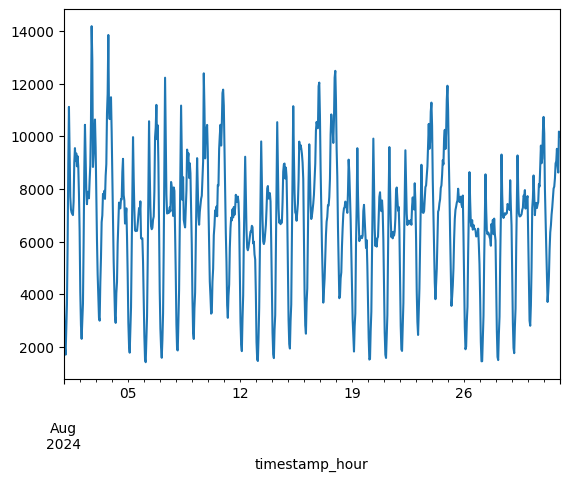

In [5]:
# Print the test set

df_test[target_col].plot()

# Modeling

### Evaluation helper function

In [6]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# We use this helper function to evaluate model performance
def evaluate(y_true, y_pred):
    """
    This helper function prints the performance metrics of the model
    """
    # Evaluate the model using RMSE and MAE
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Print the model metrics
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R2: {r2}')
    print(f'MAPE: {mape}\n')

    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

# We store the model performance metrics in this dictionary:
metrics_per_model = {}

### Baseline

Use previous week's data

In [30]:
df_naive = pd.DataFrame(df[(df['txn_date'] >= '2024-07-25') & (df['txn_date'] <= '2024-08-31')][target_col])
df_naive['forecast_d-1'] = df_naive[target_col].shift(24)
df_naive['forecast_w-1'] = df_naive[target_col].shift(7 * 24)
df_naive = df_naive[df['txn_date'] >= '2024-08-01'] # Filter Aug 2024 data
display(df_naive.head())

print("d-1")
_ = evaluate(df_naive[target_col], df_naive["forecast_d-1"])
print("\n")

print("W-1")
naive_eval_metrics_test = evaluate(df_naive[target_col], df_naive["forecast_w-1"])

C:\Users\tonba\AppData\Local\Temp\ipykernel_10168\3718523736.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_naive = df_naive[df['txn_date'] >= '2024-08-01'] # Filter Aug 2024 data


,num_txns_Lyft,forecast_d-1,forecast_w-1
timestamp_hour,,,
2024-08-01 00:00:00,5314,4591.0,5174.0
2024-08-01 01:00:00,3229,2806.0,2973.0
2024-08-01 02:00:00,1970,1797.0,1911.0
2024-08-01 03:00:00,1707,1544.0,1724.0
2024-08-01 04:00:00,2682,2311.0,2519.0


d-1
MAE: 1118.5456989247311
MSE: 2947958.1478494625
RMSE: 1716.9618946993153
R2: 0.490818274409884
MAPE: 20.084742310894768



W-1
MAE: 515.5295698924731
MSE: 571918.7580645161
RMSE: 756.2531044990931
R2: 0.9012161755616901
MAPE: 7.310133972819253



### Ridge Regression

In [8]:
from sklearn.linear_model import Ridge

# Ridge Regression model
ridge_model = Ridge(alpha=10)
ridge_model.fit(X_train_scaled, y_train) # Use scaled data

# Make predictions
y_pred_ridge = ridge_model.predict(X_test_scaled) # Use scaled data

# Model evaluation
print("Train")
ridge_eval_metrics_train = evaluate(y_train, ridge_model.predict(X_train_scaled))
print("Test")
ridge_eval_metrics_test = evaluate(y_test, y_pred_ridge)

Train
MAE: 634.9489027517959
MSE: 920144.6060602188
RMSE: 959.2416828204551
R2: 0.8861078150085716
MAPE: 38.4532716778817

Test
MAE: 463.4363076934315
MSE: 423272.9040461429
RMSE: 650.5942699149316
R2: 0.9268908115825937
MAPE: 7.379906005789992



### Decision Tree

In [9]:
from sklearn.tree import DecisionTreeRegressor

def objective(trial):
    # Suggest hyperparameters to tune
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    # Initialize the model with the suggested hyperparameters
    dt_model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Train the model
    dt_model.fit(X_train, y_train)
    
    # Evaluate the model on the validation set (or test set if needed)
    y_pred = dt_model.predict(X_test)
    
    # Calculate the mean squared error
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse  # Optuna will try to minimize this

# Hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Get the best model
best_params = study.best_params
dt_model = DecisionTreeRegressor(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)

# Model evaluation
print("Train")
dt_eval_metrics_train = evaluate(y_train, dt_model.predict(X_train))
print("Test")
dt_eval_metrics_test = evaluate(y_test, y_pred_dt)

  0%|          | 0/50 [00:00<?, ?it/s]

Train
MAE: 555.5555539392553
MSE: 675066.4572726556
RMSE: 821.6242798704621
R2: 0.9164427054977773
MAPE: 20.422536845549523

Test
MAE: 454.394361169597
MSE: 427258.97650720354
RMSE: 653.6505002730462
R2: 0.9262023230925075
MAPE: 6.648864709852341



### Random Forest

In [10]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the random forest regressor
rf_model = RandomForestRegressor(n_estimators=300, 
                                 max_depth=6, 
                                 n_jobs=-1, 
                                 random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Model evaluation
print("Train")
rf_eval_metrics_train = evaluate(y_train, rf_model.predict(X_train))
print("Test")
rf_eval_metrics_test = evaluate(y_test, y_pred_rf)

Train
MAE: 576.4837075426185
MSE: 751694.9666537986
RMSE: 867.0034409699875
R2: 0.9069579046212904
MAPE: 27.56294630768593

Test
MAE: 426.7899670275245
MSE: 392608.20747394476
RMSE: 626.5845573216313
R2: 0.9321873260961119
MAPE: 6.177677396730517



### XGBoost (with hyperparameter tuning)

In [13]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters for tuning
    param = {
        'objective': 'reg:squarederror',
        'n_estimators': 300, # Keep fixed
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),  # Replaced suggest_loguniform
        'max_depth': trial.suggest_int('max_depth', 3, 7), # keep this low enough to avoid overfitting
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Replaced suggest_uniform
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Replaced suggest_uniform
        'gamma': trial.suggest_float('gamma', 0, 1),  # Replaced suggest_uniform
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e2, log=True),  # Replaced suggest_loguniform
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1e2, log=True),  # Replaced suggest_loguniform
        'n_jobs': -1,
        'random_state': 42,
        'verbosity': 0
    }
    
    # Initialize the XGBoost regressor with the suggested hyperparameters
    model = xgb.XGBRegressor(**param)
    
    # Fit the model
    model.fit(X_train, y_train, verbose=False)
    
    # Predict on the validation set
    y_pred = model.predict(X_test)
    
    # Calculate root mean squared error as the objective to minimize
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse
    
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Get the best hyperparameters found by Optuna
best_params = study.best_params
print("Best hyperparameters found: ", best_params)

# Train the best model
xgb_model = xgb.XGBRegressor(**best_params, n_estimators=300, n_jobs = -1, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgboost = xgb_model.predict(X_test)

# Model evaluation
print("Train")
xgb_eval_metrics_train = evaluate(y_train, xgb_model.predict(X_train))
print("Test")
xgb_eval_metrics_test = evaluate(y_test, y_pred_xgboost)

  0%|          | 0/50 [00:00<?, ?it/s]

Best hyperparameters found:  {'learning_rate': 0.035703603505074136, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.7065513007984549, 'colsample_bytree': 0.5187819388273576, 'gamma': 0.4125497489936705, 'reg_alpha': 55.38957856006014, 'reg_lambda': 0.6084352302152216}
Train
MAE: 303.41442120473965
MSE: 176860.09607802462
RMSE: 420.5473767342089
R2: 0.9781088943548054
MAPE: 11.209860277409742

Test
MAE: 388.36929993988366
MSE: 318683.0007683516
RMSE: 564.5201508966279
R2: 0.9449559484533931
MAPE: 5.658427706965121



### Deep Neural Network

In [36]:
from sklearn.neural_network import MLPRegressor

# Fit the regression model
nn_model = MLPRegressor(hidden_layer_sizes=(80, 100, 120, 80, 60), 
                        activation="relu",
                        solver="adam", 
                        #learning_rate="",
                        #learning_rate_init=0.3,
                        max_iter=500, 
                        random_state=42, 
                        verbose=True,
                        shuffle=False # NOTE THAT THIS IS TIME SERIES DATA NO SHUFFLING ALLOWED
                       )
nn_model.fit(X_train_scaled, y_train) # Use scaled data

# Make predictions
y_pred_nn = nn_model.predict(X_test_scaled) # Use scaled data

# Model evaluation
print("Train")
nn_eval_metrics_train = evaluate(y_train, nn_model.predict(X_train_scaled))
print("Test")
nn_eval_metrics_test = evaluate(y_test, y_pred_nn)

Iteration 1, loss = 23180362.40441215
Iteration 2, loss = 1699103.08550791
Iteration 3, loss = 936829.97526697
Iteration 4, loss = 775055.18560962
Iteration 5, loss = 686569.57797048
Iteration 6, loss = 625349.52301610
Iteration 7, loss = 579493.99737037
Iteration 8, loss = 544261.48228290
Iteration 9, loss = 516768.52113200
Iteration 10, loss = 495337.34581527
Iteration 11, loss = 477943.22202136
Iteration 12, loss = 465722.77348066
Iteration 13, loss = 454760.25361664
Iteration 14, loss = 445443.54166782
Iteration 15, loss = 437394.41416452
Iteration 16, loss = 430192.14700632
Iteration 17, loss = 423687.33483569
Iteration 18, loss = 417601.31888243
Iteration 19, loss = 411795.21648269
Iteration 20, loss = 406245.55243175
Iteration 21, loss = 400915.20859770
Iteration 22, loss = 395985.51924963
Iteration 23, loss = 391229.96959271
Iteration 24, loss = 386881.66014972
Iteration 25, loss = 382812.12386495
Iteration 26, loss = 378851.61970666
Iteration 27, loss = 375355.02574050
Iterati

# Model Comparisons

### Time Series Plots

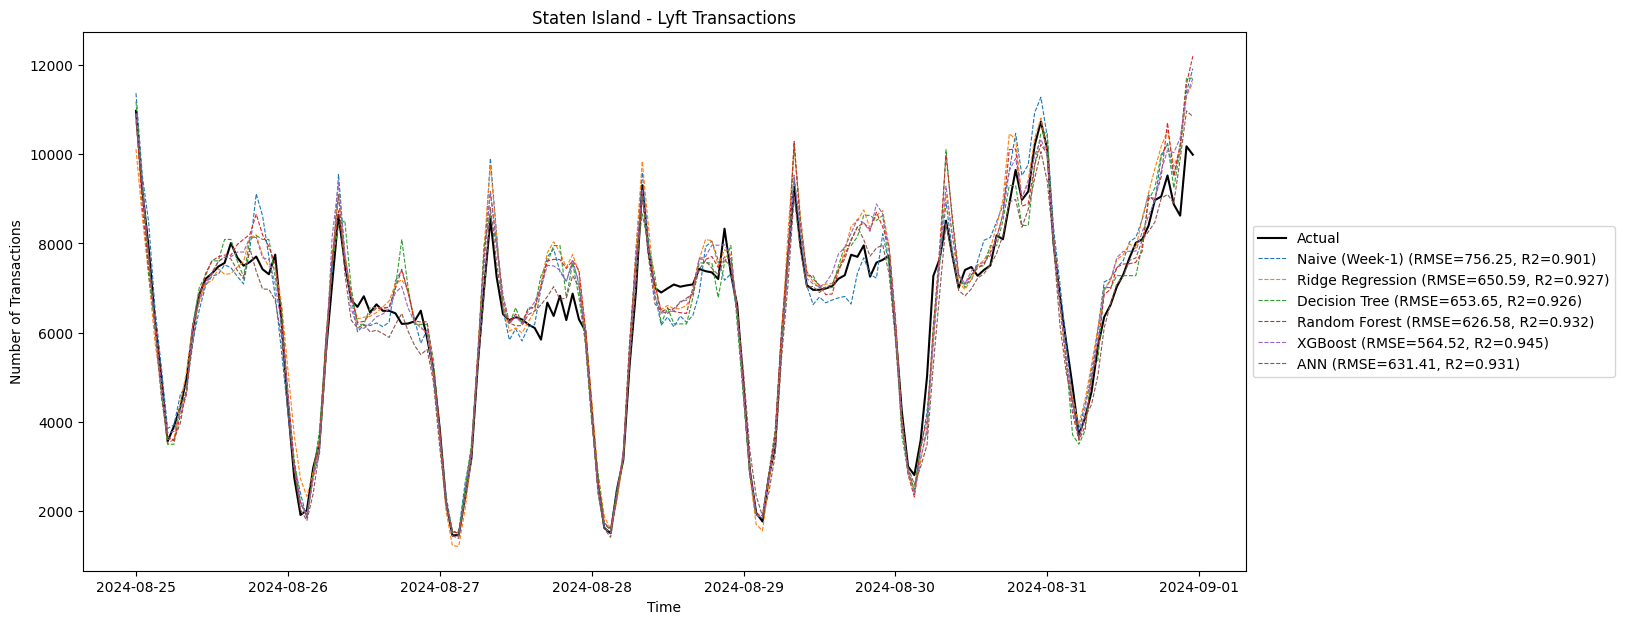

In [41]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 7))


num_hrs = 168
# Plotting the predictions
ax.plot(df_test.index[-num_hrs:], df_test[target_col][-num_hrs:], label="Actual", color='black', lw=1.5)
ax.plot(df_test.index[-num_hrs:], df_naive["forecast_w-1"][-num_hrs:], label=f"Naive (Week-1) (RMSE={naive_eval_metrics_test['RMSE']:.2f}, R2={naive_eval_metrics_test['R2']:.3f})", ls='--', lw=.8)
ax.plot(df_test.index[-num_hrs:], y_pred_ridge[-num_hrs:], label=f"Ridge Regression (RMSE={ridge_eval_metrics_test['RMSE']:.2f}, R2={ridge_eval_metrics_test['R2']:.3f})", ls='--', lw=.8)
ax.plot(df_test.index[-num_hrs:], y_pred_dt[-num_hrs:], label=f"Decision Tree (RMSE={dt_eval_metrics_test['RMSE']:.2f}, R2={dt_eval_metrics_test['R2']:.3f})", ls='--', lw=.8)
ax.plot(df_test.index[-num_hrs:], y_pred_rf[-num_hrs:], label=f"Random Forest (RMSE={rf_eval_metrics_test['RMSE']:.2f}, R2={rf_eval_metrics_test['R2']:.3f})", ls='--', lw=.8)
ax.plot(df_test.index[-num_hrs:], y_pred_xgboost[-num_hrs:], label=f"XGBoost (RMSE={xgb_eval_metrics_test['RMSE']:.2f}, R2={xgb_eval_metrics_test['R2']:.3f})", ls='--', lw=.8)
ax.plot(df_test.index[-num_hrs:], y_pred_nn[-num_hrs:], label=f"ANN (RMSE={nn_eval_metrics_test['RMSE']:.2f}, R2={nn_eval_metrics_test['R2']:.3f})", ls='--', lw=.8)

# Adding labels, title, and legend for better clarity
ax.set_xlabel('Time')
ax.set_ylabel('Number of Transactions')
ax.set_title(f'{borough} - {ride_type} Transactions')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

img_filename = rf"../../data/images/{ride_type} ({borough}) - model comparison.jpeg"
plt.savefig(img_filename, dpi=300, bbox_inches='tight')
plt.show()

### Model Performance